# Experimentation with `FNO` operator

In this notebook there are some experiments with the `FNO` operator. 

The experiments:
- ☑ 1. Test change of modes in the `FNO` operator
- ☒ 2. Change training with different number of data points
- ☒ 3. Test different resolution of the training data
- ☒ 4. Make comparison with the differnt tranings



## Libraries


In [1]:
from FNO.fno_2d_time import FNO2DTime
from FNO.lploss import LpLoss
from FNO.train import train_model
from utilities.utils import MatlabFileReader
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import timeit

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

NVIDIA GeForce RTX 3050 Laptop GPU


## Data

In [2]:
math_path = "NavierStokes_V1e-5_N1200_T20.mat"
math_data = MatlabFileReader(math_path, device=device, to_tensor=True).read_file("u")
math_data.shape

torch.Size([1200, 64, 64, 20])

## 1. Test change of modes in the `FNO` operator

In [33]:
# Create an instance of the model
fno_model = FNO2DTime(modes=4).cuda()

In [34]:
# Prepare the data, remember, t = [0, 10] is for input(u), t = [10, 20] is for output(a)
train_data = math_data[:1000, :, :, :].cuda()
test_data = math_data[1000:, :, :, :].cuda()

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data[:, :, :, :10], train_data[:, :, :, 10:]), 
    batch_size=50, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data[:, :, :, :10], test_data[:, :, :, 10:]),
    batch_size=50, shuffle=True)

In [35]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [36]:
# Train the model
loss1, mse1 = train_model(model=fno_model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [47:39<00:00, 28.60s/it]


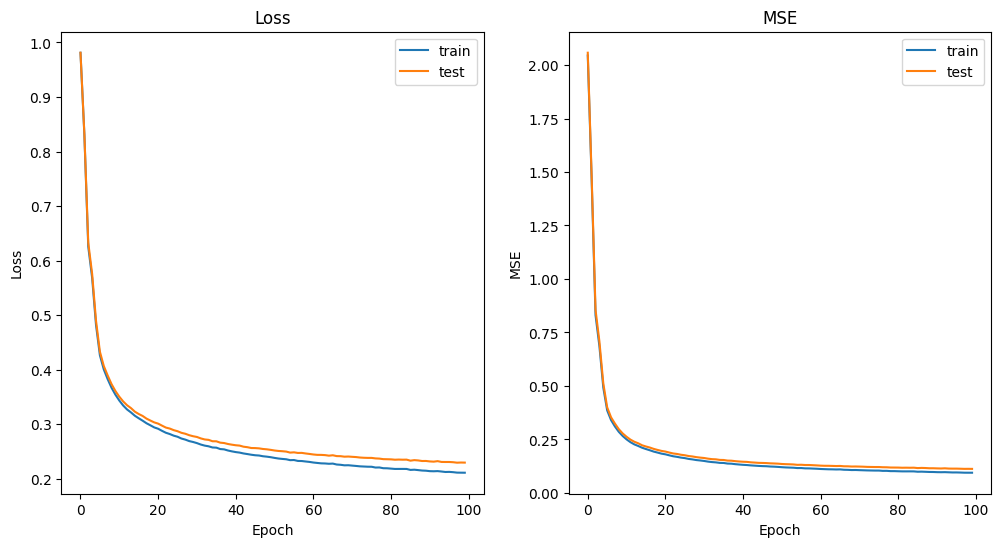

In [39]:
# Plot the loss and mse
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss1, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse1, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [38]:
# Save the model
torch.save(fno_model, "FNO_2D_Time_100epochs_NavierStokes_4modes.pt")

## 2. Change training with different number of data points

In [28]:
# Instantiate a new model
fno_model_2 = FNO2DTime().cuda()

In [29]:
# Prepare the data, remember, t = [0, 10] is for input(u), t = [10, 20] is for output(a)
train_data = math_data[:500, :, :, :].cuda()
eval_data = math_data[500:600, :, :, :].cuda()

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data[:, :, :, :10], train_data[:, :, :, 10:]), 
    batch_size=50, shuffle=True)

eval_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(eval_data[:, :, :, :10], eval_data[:, :, :, 10:]),
    batch_size=50, shuffle=True)

In [30]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [31]:
# Train the model
loss2, mse2 = train_model(model=fno_model_2,
                        train_dataloader=train_loader,
                        test_dataloader=eval_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [23:53<00:00, 14.33s/it]


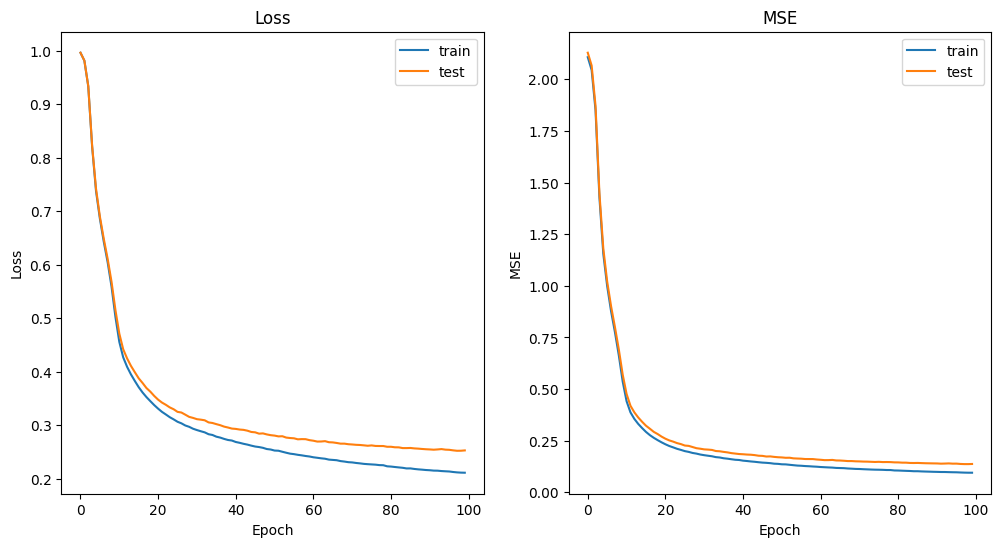

In [32]:
# Plot the loss and mse
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss2, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse2, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [33]:
# Save the model
torch.save(fno_model_2, "FNO_2D_Time_100epochs_NavierStokes_500samples.pt")

## 3. Test different resolution of the training data

In [34]:
# Instantiate a new model
fno_model_3 = FNO2DTime().cuda()

In [35]:
# Prepare the data
train_data = math_data[:1000, :, :, :].cuda()
test_data = math_data[1000:, :, :, :].cuda()

# Change resolution of [, 64, 64, :] to [, 32, 32, :]
train_data = torch.nn.functional.interpolate(train_data.permute(0, 3, 1, 2), size=(32, 32)).permute(0, 2, 3, 1)
# test_data = torch.nn.functional.interpolate(test_data.permute(0, 3, 1, 2), size=(32, 32)).permute(0, 2, 3, 1)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data[:, :, :, :10], train_data[:, :, :, 10:]), 
    batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data[:, :, :, :10], test_data[:, :, :, 10:]),
    batch_size=50, shuffle=True)

In [36]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [37]:
# Train the model
loss3, mse3 = train_model(model=fno_model_3,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


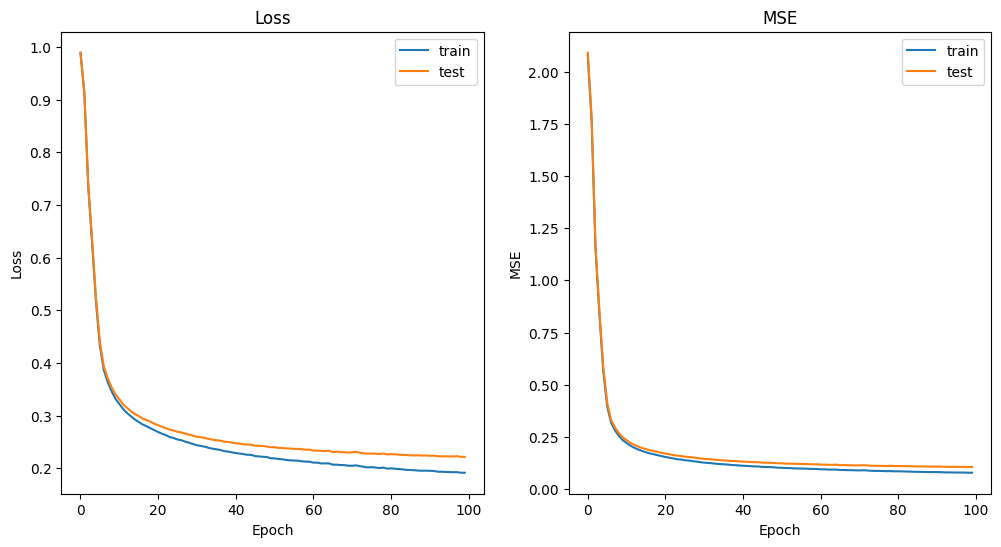

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss3, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse3, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [39]:
# Save the model
torch.save(fno_model_3, "FNO_2D_Time_100epochs_NavierStokes_32x32.pt")

In [41]:
# Instantiate a new model
fno_model_4 = FNO2DTime().cuda()

In [40]:
# Prepare the data
train_data = math_data[:1000, :, :, :].cuda()
test_data = math_data[1000:, :, :, :].cuda()

# Change resolution of [, 64, 64, :] to [, 16, 16, :]
train_data = torch.nn.functional.interpolate(train_data.permute(0, 3, 1, 2), size=(16, 16)).permute(0, 2, 3, 1)
# test_data = torch.nn.functional.interpolate(test_data.permute(0, 3, 1, 2), size=(16, 16)).permute(0, 2, 3, 1)

print(train_data.shape)
print(test_data.shape)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data[:, :, :, :10], train_data[:, :, :, 10:]), 
    batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_data[:, :, :, :10], test_data[:, :, :, 10:]),
    batch_size=50, shuffle=True)

torch.Size([1000, 16, 16, 20])
torch.Size([200, 64, 64, 20])


In [42]:
# Train the model
loss4, mse4 = train_model(model=fno_model_4,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


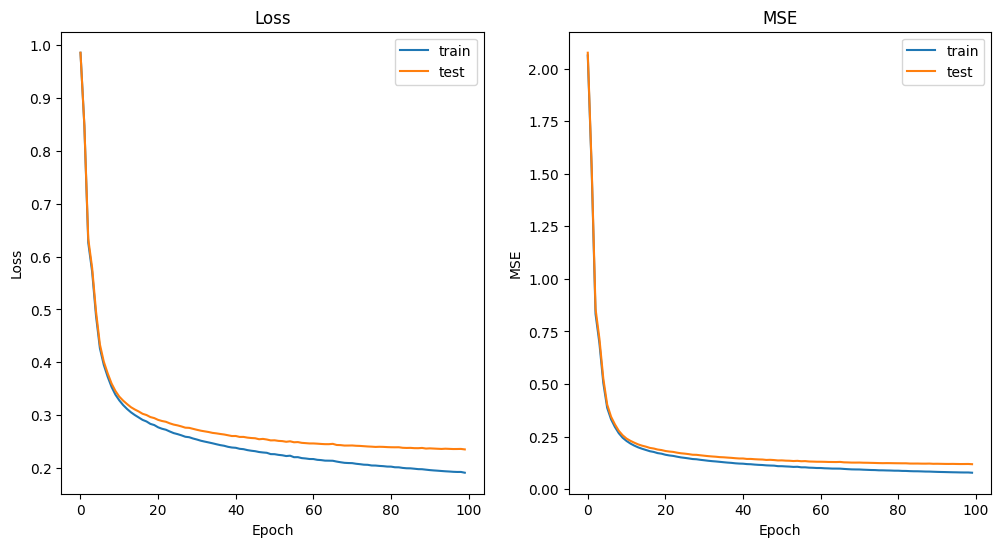

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss4, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse4, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [44]:
# Save the model
torch.save(fno_model_3, "FNO_2D_Time_100epochs_NavierStokes_16x16.pt")

## Comparison with the different models

We will compare the different models with the following metrics:

- Mean squared error
- Mean absolute error

To compare the models we will make predictions with diferent data points, calculate the metrics and plot the results.

In [3]:
# Read the data
math_path = "NavierStokes_V1e-5_N1200_T20.mat"
math_data = MatlabFileReader(math_path, device=device, to_tensor=True).read_file("u")

# Extract last 100 samples for testing
test_data = math_data[1100:, :, :, :].cuda()
test_data.shape

torch.Size([100, 64, 64, 20])

In [2]:
# Instance each model
fno_model_1 = torch.load("FNO_2D_Time_100epochs_NavierStokes_4modes.pt").cuda()
fno_model_2 = torch.load("FNO_2D_Time_100epochs_NavierStokes_500samples.pt").cuda()
fno_model_3 = torch.load("FNO_2D_Time_100epochs_NavierStokes_32x32.pt").cuda()
fno_model_4 = torch.load("FNO_2D_Time_100epochs_NavierStokes_16x16.pt").cuda()
fno_model_5 = torch.load("fno_navierstokes_v1e-5_500epchs_1000datapoints.pt").cuda()

In [15]:
# Make predictions for each model
with torch.no_grad():
    pred1 = fno_model_1(test_data[:, :, :, :10])
    pred2 = fno_model_2(test_data[:, :, :, :10])
    pred3 = fno_model_3(test_data[:, :, :, :10])
    pred4 = fno_model_4(test_data[:, :, :, :10])
    pred5 = fno_model_5(test_data[:, :, :, :10])

In [25]:
# Count time of prediction
start = timeit.default_timer()
with torch.no_grad():
    pred1 = fno_model_1(test_data[:, :, :, :10])
stop = timeit.default_timer()
print('Time: ', stop - start)


Time:  0.015624699997715652


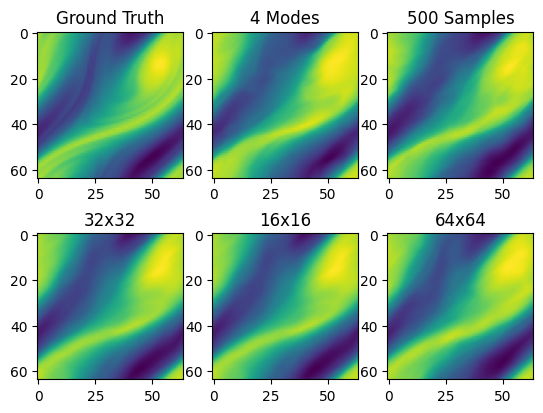

In [8]:
# Make plots
fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(test_data[0, :, :, 10].cpu().numpy())
ax[0][0].set_title("Ground Truth")
ax[0][1].imshow(pred1[0, :, :, 0].cpu().numpy())
ax[0][1].set_title("4 Modes")
ax[0][2].imshow(pred2[0, :, :, 0].cpu().numpy())
ax[0][2].set_title("500 Samples")
ax[1][0].imshow(pred3[0, :, :, 0].cpu().numpy())
ax[1][0].set_title("32x32")
ax[1][1].imshow(pred4[0, :, :, 0].cpu().numpy())
ax[1][1].set_title("16x16")
ax[1][2].imshow(pred5[0, :, :, 0].cpu().numpy())
ax[1][2].set_title("64x64")
plt.show()

In [53]:
(np.abs(test_data[0, :, :, 10].cpu().numpy() - pred1[0, :, :, 0, 0].cpu().numpy())).min()

3.3140182e-05

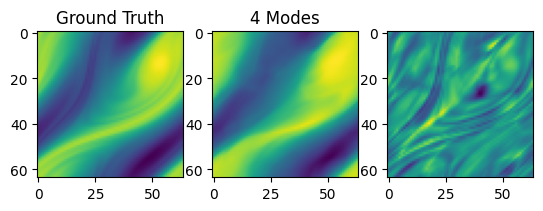

In [42]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(test_data[0, :, :, 10].cpu().numpy())
ax[0].set_title("Ground Truth")
ax[1].imshow(pred1[0, :, :, 0, 0].cpu().numpy())
ax[1].set_title("4 Modes")
ax[2].imshow(test_data[0, :, :, 10].cpu().numpy() - pred1[0, :, :, 0, 0].cpu().numpy())

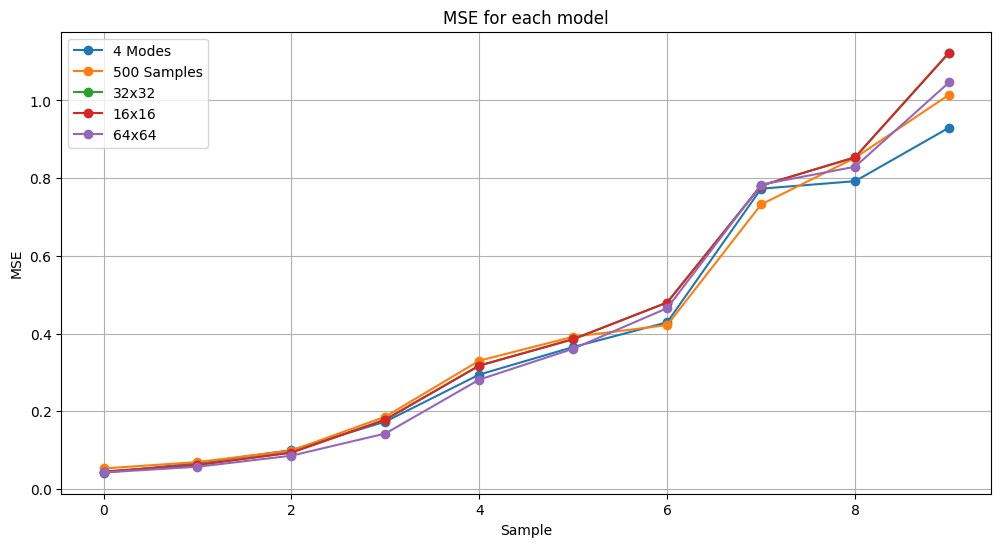

In [67]:
# Calculate the error
error1, error2, error3, error4, error5 = [], [], [], [], []
for i in range(10):
    error1.append(F.mse_loss(test_data[0, :, :, 9+i], pred1[0, :, :, i, 0]).item())
    error2.append(F.mse_loss(test_data[0, :, :, 9+i], pred2[0, :, :, i, 0]).item())
    error3.append(F.mse_loss(test_data[0, :, :, 9+i], pred3[0, :, :, i, 0]).item())
    error4.append(F.mse_loss(test_data[0, :, :, 9+i], pred4[0, :, :, i, 0]).item())
    error5.append(F.mse_loss(test_data[0, :, :, 9+i], pred5[0, :, :, i, 0]).item())
    
# Plot the error
fig = plt.figure(figsize=(12, 6))
plt.plot(error1, "o-", label="4 Modes")
plt.plot(error2, "o-", label="500 Samples")
plt.plot(error3, "o-", label="32x32")
plt.plot(error4, "o-", label="16x16")
plt.plot(error5, "o-", label="64x64")
plt.xlabel("Sample")
plt.ylabel("MSE")
plt.title("MSE for each model")
plt.legend()
plt.grid()
plt.show()

## Test zero-shot learning


In [9]:
data_new = np.load("u (1).npy")
data_new.shape

(10, 256, 256, 20)

In [10]:
with torch.no_grad():
    pred_new = fno_model_5(torch.tensor(data_new[:, :, :, :10]).cuda())

In [11]:
pred_new.shape

torch.Size([10, 256, 256, 10, 1])

MovieWriter ffmpeg unavailable; using Pillow instead.


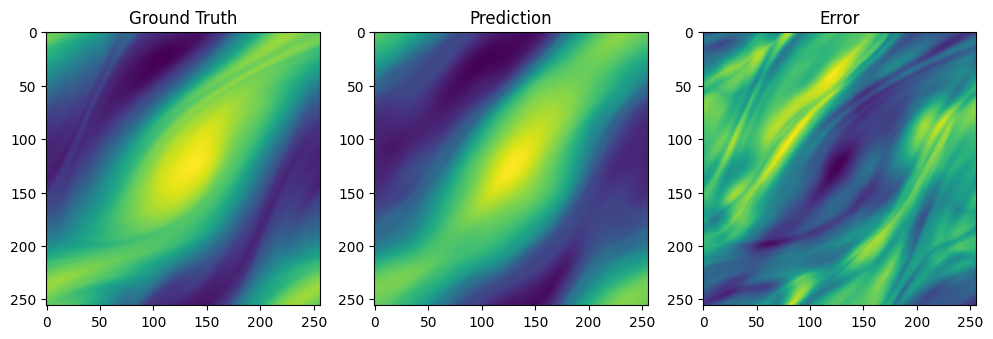

In [92]:
# Make animation with predictions
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(data_new[0, :, :, 9])
ax[0].set_title("Ground Truth")
ax[1].imshow(pred_new[0, :, :, 0].cpu().numpy())
ax[1].set_title("Prediction")
ax[2].imshow(data_new[0, :, :, 9] - pred_new[0, :, :, 0, 0].cpu().numpy())
ax[2].set_title("Error")

def animate(i):
    ax[0].imshow(data_new[0, :, :, 9+i])
    ax[1].imshow(pred_new[0, :, :, 0+i].cpu().numpy())
    ax[2].imshow(data_new[0, :, :, 9+i] - pred_new[0, :, :, i, 0].cpu().numpy())
    
ani = animation.FuncAnimation(fig, animate, frames=10, interval=500)
ani.save("FNO_NavierStokes_forced_function.gif")

In [22]:
data_new[0, :, :, 9+i], pred_new[0, :, :, i, 0]

(array([[0.74065816, 0.7406015 , 0.7414378 , ..., 0.7504116 , 0.7452156 ,
         0.7420578 ],
        [0.75245106, 0.7546739 , 0.75706303, ..., 0.7506869 , 0.7500034 ,
         0.7507491 ],
        [0.7689607 , 0.7721031 , 0.77488714, ..., 0.76008546, 0.7626072 ,
         0.7656951 ],
        ...,
        [0.7575276 , 0.7451987 , 0.7342477 , ..., 0.7971802 , 0.7840671 ,
         0.77068317],
        [0.7424381 , 0.7339555 , 0.72744226, ..., 0.7769758 , 0.7644292 ,
         0.7527299 ],
        [0.73661196, 0.7327548 , 0.7305707 , ..., 0.7599715 , 0.75027525,
         0.7424274 ]], dtype=float32),
 tensor([[1.0321, 1.0245, 1.0169,  ..., 1.0558, 1.0465, 1.0387],
         [1.0183, 1.0103, 1.0030,  ..., 1.0434, 1.0354, 1.0278],
         [1.0038, 0.9962, 0.9892,  ..., 1.0312, 1.0233, 1.0158],
         ...,
         [1.0652, 1.0594, 1.0517,  ..., 1.0913, 1.0819, 1.0732],
         [1.0548, 1.0468, 1.0392,  ..., 1.0790, 1.0699, 1.0623],
         [1.0425, 1.0351, 1.0268,  ..., 1.0669, 1.0587,

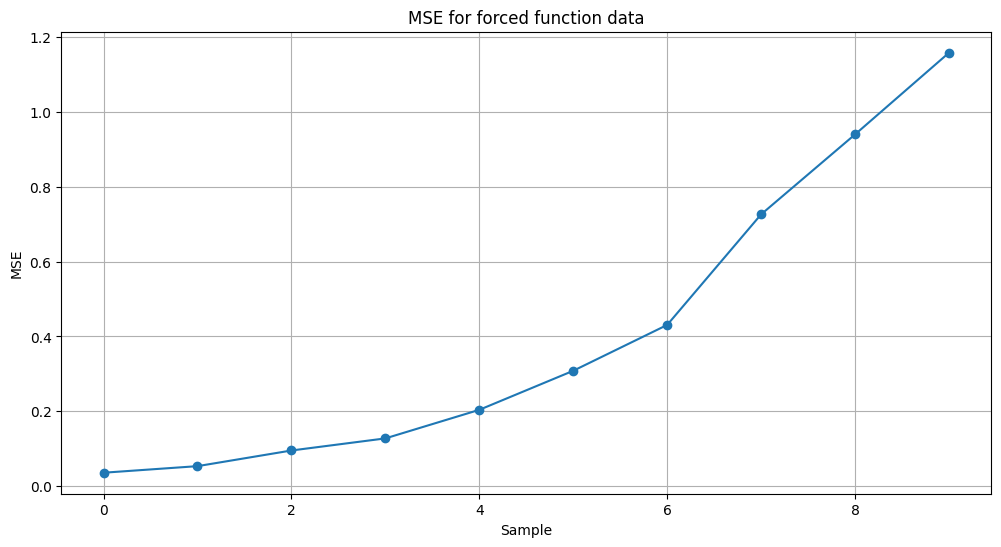

In [26]:
# Plot the error
error = []
for i in range(10):
    error.append(F.mse_loss(pred_new[0, :, :, i, 0], torch.tensor(data_new[0, :, :, 9+i]).cuda()).item())
    
fig = plt.figure(figsize=(12, 6))
plt.plot(error, "o-")
plt.xlabel("Sample")
plt.ylabel("MSE")
plt.title("MSE for forced function data")
plt.grid()
plt.show()

## Test super-resolution

In [3]:
data_256 = np.load("u.npy")

In [4]:
data_256.shape

(100, 512, 512, 20)

In [5]:
# Make predictions
with torch.no_grad():
    pred_256 = fno_model_5(torch.tensor(data_256[0:1, :, :, :10]).cuda())

MovieWriter ffmpeg unavailable; using Pillow instead.


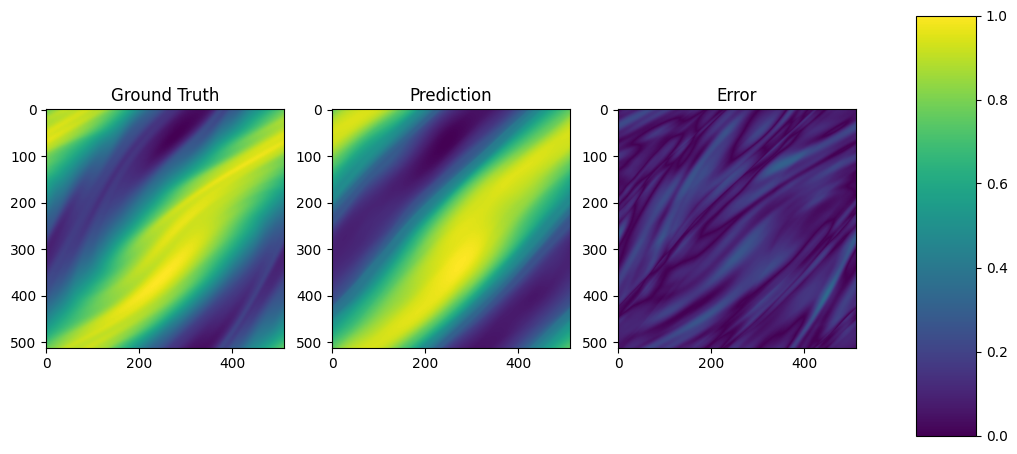

In [6]:
# Make animation with predictions
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(data_256[0, :, :, 9])
ax[0].set_title("Ground Truth")
ax[1].imshow(pred_256[0, :, :, 0].cpu().numpy())
ax[1].set_title("Prediction")
ax[2].imshow(data_256[0, :, :, 9] - pred_256[0, :, :, 0, 0].cpu().numpy(), vmin=0, vmax=1)
ax[2].set_title("Error")

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[2].imshow(data_256[0, :, :, 9] - pred_256[0, :, :, 0, 0].cpu().numpy(), vmin=0, vmax=1), cax=cbar_ax)

def animate(i):
    ax[0].imshow(data_256[0, :, :, 9+i])
    ax[1].imshow(pred_256[0, :, :, 0+i].cpu().numpy())
    ax[2].imshow(np.abs(data_256[0, :, :, 9+i] - pred_256[0, :, :, i, 0].cpu().numpy()), vmin=0, vmax=1)
    
ani = animation.FuncAnimation(fig, animate, frames=10, interval=500)
ani.save("FNO_NavierStokes_super_resolution512_model64.gif")

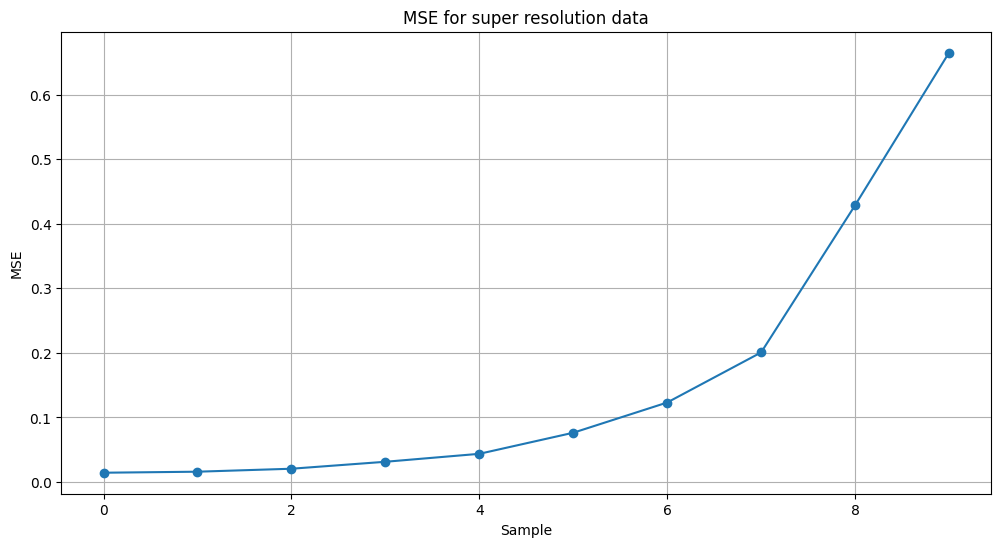

In [27]:
# Plot the error
error = []
for i in range(10):
    error.append(F.mse_loss(pred_256[0, :, :, i, 0], torch.tensor(data_256[0, :, :, 9+i]).cuda()).item())
    
fig = plt.figure(figsize=(12, 6))
plt.plot(error, "o-")
plt.xlabel("Sample")
plt.ylabel("MSE")
plt.title("MSE for super resolution data")
plt.grid()
plt.show()